This is a Jupyter notebook showing my progression in understanding 3Blue1Brown's [neural network series](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi). I'm beginning by starting with the "Hello World" of neural networks, that being a network that can take in handwritten digits between 0 and 9 and tell you which digit it is.

In [35]:
# Start with the usual imports
import numpy as np
from scipy.special import expit # sigmoid function

Here, I'm using the MNIST dataset, which contains over 50,000 different handwritten digits. The dataset comes from Michael Nielsen's [repository](https://github.com/mnielsen/neural-networks-and-deep-learning/tree/master/data) for his book on neural networks, [*Neural Networks and Deep Learning*](http://neuralnetworksanddeeplearning.com/) (free to read online).

With this said, we of course start by loading the dataset.

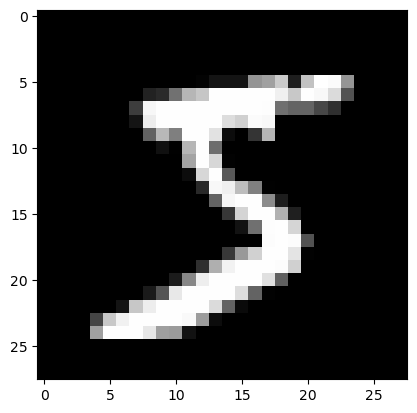

In [36]:
"""
Most of this code was from https://stackoverflow.com/a/25079162/18031673.
I tweaked it a bit for formatting, and added the encoding bit myself. 
"""
import gzip
import pickle
import matplotlib.cm as cm
import matplotlib.pyplot as plt


# Load MNIST dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    # This was likely encoded in Python2---to fix, using encoding 'latin1'
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
# train_x: inputs (pictures of digits)
# train_y: outputs (labels of digits)
train_x, train_y = train_set


# Show an example image (the first image in the training dataset)
plt.imshow(train_x[0].reshape((28, 28)), cmap=cm.Greys_r)
plt.show()

With the dataset loaded, we can begin constructing the neural network. I use the following list of constant integers to represent the network's dimensions (which are, at this point, identical to the ones shown in 3Blue1Brown's video.)

In [37]:
# Using the same shape as in 3Blue1Brown's Video
LAYER_HEIGHTS = [
    train_x.shape[1], # 784
    16,
    16,
    10, # Number of digits in base 10
]

We then initialize the weight matrices, which we organize in a larger array that I name `weights`. Although there are 4 layers in the network, we need 3 weight matrices so that each pair of layers has their own weight matrix.

In [38]:
# Initialize random -list of weight matrices
weights = np.empty(len(LAYER_HEIGHTS) - 1, dtype=object)

np.random.seed(42)
for i in range(1, len(weights)+1):
    weights[i-1] = np.random.uniform(-2, 2, (LAYER_HEIGHTS[i], LAYER_HEIGHTS[i-1]))
weights

array([array([[-0.50183952,  1.80285723,  0.92797577, ...,  0.17089777,
               -0.99280376, -0.61721603],
              [-1.27360913,  1.63380225,  0.33356718, ..., -0.30504699,
                0.6701996 , -1.61785874],
              [ 0.4954373 , -0.19292929,  0.34643385, ..., -1.95947526,
                0.54438419,  1.65314779],
              ...,
              [-1.92571712,  1.55457068, -1.09239693, ...,  0.67344281,
                0.96059757, -0.2074852 ],
              [ 1.75010395,  0.94662694, -0.16830168, ...,  1.35648641,
                1.63887325,  0.036981  ],
              [ 0.77709899, -1.55279852,  0.26115584, ..., -0.29539381,
                1.78337764, -1.12908386]])                             ,
       array([[-0.97303359, -1.59644479,  0.4222811 ,  0.7194915 ,  0.57172483,
                1.44452097, -0.05429666, -1.46217184, -0.84237948,  0.64971989,
                0.45248789,  0.12401252,  0.73185767,  0.5495634 ,  1.52529956,
                0.34406551

Similiarly, we organize an array containing 3 bias vectors, one for each pair of layers.

In [39]:
# Random biases
biases = np.empty(len(LAYER_HEIGHTS) - 1, dtype=object)
for i in range(len(biases)):
    biases[i] = np.random.uniform(-2, 2, LAYER_HEIGHTS[i+1])
biases

array([array([-1.98598135, -1.88948098,  1.29536206, -1.20214925, -1.75692293,
              -1.05140771, -0.29559938,  0.92226508,  0.49734211, -1.04951513,
               0.01308179,  1.70485642,  1.26003111, -0.70724086,  1.92905825,
               0.8344816 ])                                                   ,
       array([-1.75020258, -1.85935715, -1.3263682 ,  0.91142347, -1.2650443 ,
               0.04594708, -1.62695952,  1.68354463, -0.62415755,  1.63252823,
               1.77950257, -1.97548541, -0.14345925, -1.90137578,  1.63477107,
               0.07363018])                                                   ,
       array([-1.70022395, -1.55889309, -0.4659639 ,  1.76093677,  0.77163661,
               1.47047546, -0.53417341, -1.8271452 ,  1.89727055, -1.93130804])],
      dtype=object)

Our activations for the first layer will be the "flatted" array of grayscale pixel values that represent a white digit drawn onto a black board. Let's start with a test run with a single arbitrarily chosen digit and see how well the network does with our randomly initialized weights and biases.

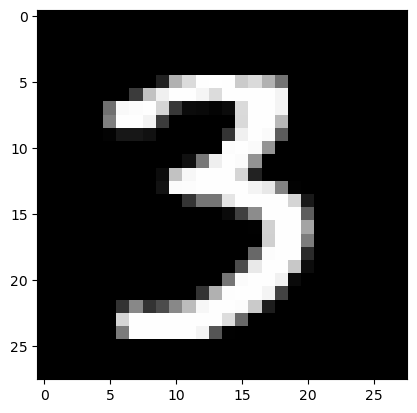

In [40]:
test_index = 10000 # chose this index because I liked the way the number looked
activations = np.empty(len(LAYER_HEIGHTS), dtype=object) # empty activations array to contain activations for all layers

activations[0] = train_x[test_index]
plt.imshow(activations[0].reshape((28, 28)), cmap=cm.Greys_r)
plt.show()

We calculate each layer's activation vector using the formula
$$
\mathbf{a}^{(i)} = \sigma\left(\mathbf{W}_{i-1}\mathbf{a}^{(i-1)} + \mathbf{b}_{i-1}\right)
$$
Where $\mathbf{a}^{(i)}$ is the activation vector, $\mathbf{W}_{i-1}$ is the weight matrix, and $\mathbf{b}_{i-1}$ is the bias vector, each indexed based on which layer they correspond to, for $i \in \{1, 2, 3\}$. Moreover, $\sigma$ is the sigmoid function. Although 3Blue1Brown mentioned that the ReLU function tends to be a better activation function, I want to stick to the sigmoid function for now since it seems like that's what he used in the video. Plus, I prefer the sigmoid function's output for now, since tells us the network's level of confidence with its answer, which I personally like.

Continuing, we implement each activation vector's calculation as follows:

In [41]:
for i in range(1, len(activations)):
    activations[i] = expit(weights[i-1] @ activations[i-1] + biases[i-1])
# Not showing the first layer's activations, since we technically already saw it because of the image before
activations[1:] 

array([array([9.33231892e-01, 9.99625620e-01, 9.21778290e-03, 9.97926584e-01,
              9.99738418e-01, 9.98369802e-01, 9.99565148e-01, 1.39248314e-01,
              4.57126727e-02, 4.38513258e-06, 4.20900529e-05, 8.25153688e-01,
              8.92942470e-04, 9.96614620e-01, 9.09691699e-01, 2.05859928e-02]),
       array([0.55736516, 0.72381646, 0.93501558, 0.24846419, 0.9546275 ,
              0.69358096, 0.02277593, 0.4202985 , 0.77087925, 0.98108154,
              0.76277771, 0.35634925, 0.40917132, 0.05664381, 0.25729164,
              0.9756615 ])                                               ,
       array([0.03038738, 0.0884819 , 0.86890401, 0.76028722, 0.63023341,
              0.74474981, 0.99944194, 0.40550893, 0.63899321, 0.4896489 ])],
      dtype=object)

If we focus our attention on the last array, we see this network performed pretty poorly. Although it did tell us we are looking at a 3 with around 76% confidence, it also told us that we were looking at a 6 with 99.9% confidence. So, as expected when using random weights and biases, this did not do well. If we continue by looking at the cost function:

In [43]:
correct_digit = train_y[test_index]
label = np.zeros(LAYER_HEIGHTS[-1])
label[correct_digit] = 1
print(label)

# Cost
sum((activations[-1] - label)**2)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


np.float64(3.5844453233337132)

We see that our cost is pretty high.

Let us proceed by using these same random weights and biases, and find the average cost across all 50,000 entries of our training data. This will amount to doing exactly what we did before, only in a larger `for` loop.

In [67]:
from tqdm import tqdm

print(train_x.shape)

costs = np.zeros(train_x.shape[0]) # storing all individual costs here

for i in tqdm(range(len(costs))):
    activations = np.empty(len(LAYER_HEIGHTS), dtype=object)
    # Feed-Forward
    activations[0] = train_x[i]
    for j in range(1, len(activations)):
        activations[j] = expit(weights[j-1] @ activations[j-1] + biases[j-1])
    
    # Create "correct final layer"
    correct_digit = train_y[i]
    label = np.zeros(LAYER_HEIGHTS[-1])
    label[correct_digit] = 1

    # Cost for this prediction
    costs[i] = sum((activations[-1] - label)**2)

(50000, 784)


100%|██████████| 50000/50000 [00:02<00:00, 20145.60it/s]


In [69]:
# Total cost
costs.mean()

np.float64(3.550455196767095)